In [1]:
!pip install transformers
!pip install scikit-learn
!pip install torch
!pip install pandas
!pip install numpy
!pip install seaborn
!pip install tqdm
!pip install sentence_transformers umap hdbscan
!pip install --upgrade umap-learn

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 44.0 MB/s eta 0:00:00
  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3542 sha256=742c3271c0d8e81702a3c96ccc337b21854b994f4088fe8dd11872433b22e333
  Stored in directory: /root/.cache/pip/wheels/15/f1/28/53dcf7a309118ed35d810a5f9cb995217800f3f269ab5771cb
Successfully built umap
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 5.6 MB/s eta 0:00:00


In [2]:
import os
from google.colab import drive
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
from tqdm.auto import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from sentence_transformers import SentenceTransformer
import umap.umap_ as umap
import hdbscan
import pickle
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import numpy as np
from collections import Counter

In [3]:
# Mount Google Drive (safely)
try:
    if not os.path.exists('/content/drive'):
        drive.mount('/content/drive')

    FILE_PATH = "/content/drive/MyDrive/amazon_reviews_backup/sampled_data_3percent"
    print("\n" + "="*50)
    print("✓ Google Drive mounted successfully")
    print("✓ File directory:", FILE_PATH)
    print("="*50 + "\n")

except Exception as e:
    print("✗ Error mounting Google Drive:", str(e))
    raise

# Cell 3: Configuration and Paths
CONFIG = {
    'MODEL_NAME': 'sentence-transformers/all-mpnet-base-v2',
    'BATCH_SIZE': 32,
    'DEVICE': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'DATA_PATH': '/content/drive/MyDrive/amazon_reviews_backup/sampled_data_3percent/',
}

# Verify paths and data
def verify_setup():
    required_files = [
        'train_processed.parquet',
        'val_processed.parquet',
        'test_processed.parquet'
    ]

    print("Checking setup...")
    print(f"Using device: {CONFIG['DEVICE']}")

    for file in required_files:
        path = os.path.join(CONFIG['DATA_PATH'], file)
        if os.path.exists(path):
            print(f"✓ Found {file}")
        else:
            print(f"✗ Missing {file}")

verify_setup()

print("\nLoading datasets...")
train_df = pd.read_parquet(f"{FILE_PATH}/train_processed.parquet")
val_df = pd.read_parquet(f"{FILE_PATH}/val_processed.parquet")
test_df = pd.read_parquet(f"{FILE_PATH}/test_processed.parquet")

# Combine for category analysis
df = pd.concat([train_df, val_df, test_df])
unique_categories = df['category'].unique().tolist()
print(f"✓ Loaded {len(df):,} total reviews")
print(f"✓ Found {len(unique_categories):,} unique categories")

# Print info before clustering
print("\n" + "="*50)
print("Before Clustering:")
print(f"Total Reviews: {len(df):,}")
print(f"Total Products: {df['asin'].nunique():,}")
print(f"Unique Categories: {len(unique_categories):,}")
print("="*50 + "\n")

# Memory cleanup
del train_df, val_df, test_df
gc.collect()

# Get embeddings with SentenceTransformer
print("\nGenerating embeddings...")
model = SentenceTransformer(CONFIG['MODEL_NAME'])
category_embeddings = model.encode(
    unique_categories,
    batch_size=CONFIG['BATCH_SIZE'],
    show_progress_bar=True,
    device=CONFIG['DEVICE']
)



Mounted at /content/drive

✓ Google Drive mounted successfully
✓ File directory: /content/drive/MyDrive/amazon_reviews_backup/sampled_data_3percent

Checking setup...
Using device: cuda
✓ Found train_processed.parquet
✓ Found val_processed.parquet
✓ Found test_processed.parquet

Loading datasets...
✓ Loaded 14,978,278 total reviews
✓ Found 33 unique categories

Before Clustering:
Total Reviews: 14,978,278
Total Products: 6,150,678
Unique Categories: 33


Generating embeddings...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

In [25]:
# DIMENSIONALITY REDUCTION AND CLUSTERING

# Reduce dimensions with UMAP
print("\nReducing dimensions with UMAP...")
umap_reducer = umap.UMAP(
    n_neighbors=5,
    n_components=3,
    min_dist=0.01,
    metric='cosine',
    random_state=42
)
umap_embeddings = umap_reducer.fit_transform(category_embeddings)

# Save the UMAP reducer
with open(f"{FILE_PATH}/umap_reducer.pkl", "wb") as f:
    pickle.dump(umap_reducer, f)

# Updated Clustering
print("\nPerforming HDBSCAN clustering...")
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=2,
    min_samples=1,
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True,
    cluster_selection_epsilon=0.5,
    alpha=0.5
)
cluster_labels = clusterer.fit_predict(umap_embeddings)

# Save the HDBSCAN clusterer
with open(f"{FILE_PATH}/hdbscan_clusterer.pkl", "wb") as f:
    pickle.dump(clusterer, f)

# Create mapping and add to DataFrame
category_to_cluster = dict(zip(unique_categories, cluster_labels))
df['meta_category'] = df['category'].map(category_to_cluster)

print("\n" + "="*50)
print("After Clustering:")
print(f"Total Reviews: {len(df):,}")
print(f"Total Products: {df['asin'].nunique():,}")
print(f"Unique Categories: {len(unique_categories):,}")  # Unchanged
print(f"Number of Clusters (excluding noise): {len(df['meta_category'].unique()) - 1:,}") #Corrected line
print("="*50 + "\n")

# Save clustered data with run information
run_id = "run_4"
output_path = f"{FILE_PATH}/amazon_reviews_clustered_{run_id}.parquet"
df.to_parquet(output_path)
print(f"\n✓ Saved clustered data to: {output_path}")


Reducing dimensions with UMAP...

Performing HDBSCAN clustering...


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



After Clustering:
Total Reviews: 14,978,278
Total Products: 6,150,678
Unique Categories: 33
Number of Clusters (excluding noise): 4


✓ Saved clustered data to: /content/drive/MyDrive/amazon_reviews_backup/sampled_data_3percent/amazon_reviews_clustered_run_4.parquet


In [26]:
# Noise ration
noise_mask = cluster_labels == -1
noise_ratio = noise_mask.sum() / len(cluster_labels)
print(f"Noise ratio: {noise_ratio:.2%}")

# Print categories marked as noise
noise_categories = [cat for cat, label in zip(unique_categories, cluster_labels) if label == -1]
print("\nCategories marked as noise:")
for cat in noise_categories:
    print(f"- {cat}")

Noise ratio: 0.00%

Categories marked as noise:


In [27]:
# Cluster size distribution

cluster_sizes = Counter(cluster_labels[cluster_labels != -1])
print("\nCluster size distribution:")
for cluster_id, size in cluster_sizes.most_common():
    print(f"Cluster {cluster_id}: {size} categories")


Cluster size distribution:
Cluster 0: 20 categories
Cluster 1: 4 categories
Cluster 2: 3 categories
Cluster 3: 3 categories
Cluster 4: 3 categories


In [29]:
# LOAD DATA AND SAVED CLUSTERING

# Load the saved UMAP reducer
with open(f"{FILE_PATH}/umap_reducer.pkl", "rb") as f:
    reducer = pickle.load(f)

# Load the saved HDBSCAN clusterer
with open(f"{FILE_PATH}/hdbscan_clusterer.pkl", "rb") as f:
    clusterer = pickle.load(f)

# Apply the saved UMAP transformation
umap_embeddings = reducer.transform(category_embeddings)

# Apply the saved HDBSCAN clusterer
cluster_labels = clusterer.fit_predict(umap_embeddings)

# Create mapping and add to DataFrame
category_to_cluster = dict(zip(unique_categories, cluster_labels))
df['meta_category'] = df['category'].map(category_to_cluster)



Evaluating clustering results...

Clustering Evaluation
Number of clusters: 5
Number of noise points: 0 (0.00%)

Cluster Size Distribution:
Cluster 0: 20 points (60.61%)
Cluster 1: 4 points (12.12%)
Cluster 2: 3 points (9.09%)
Cluster 3: 3 points (9.09%)
Cluster 4: 3 points (9.09%)

Validity Metrics:
Silhouette Score: 0.537 (higher is better, range: [-1, 1])
Calinski-Harabasz Score: 34.346 (higher is better)
Davies-Bouldin Score: 0.538 (lower is better)

HDBSCAN Metrics:
Mean cluster membership probability: 0.982
Std cluster membership probability: 0.063

Category Distribution in Clusters:

Cluster 0:
Top categories: Movies_and_TV, All_Beauty, Baby_Products, Video_Games, Kindle_Store
Average probability: 0.999

Cluster 1:
Top categories: Electronics, Automotive, Software, Appliances
Average probability: 1.000

Cluster 2:
Top categories: Industrial_and_Scientific, Tools_and_Home_Improvement, Arts_Crafts_and_Sewing
Average probability: 0.948

Cluster 3:
Top categories: Health_and_Househ

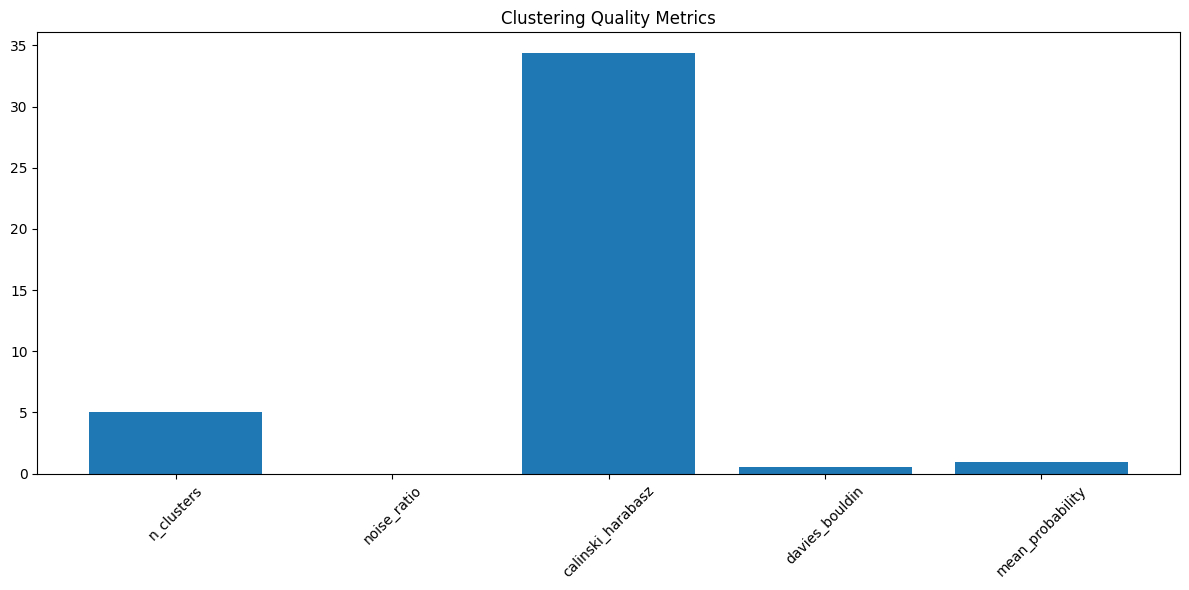


✓ Saved evaluation metrics to: /content/drive/MyDrive/amazon_reviews_backup/sampled_data_3percent/clustering_evaluation_metrics.csv


In [30]:
# CLUSTERING EVALUATION

def evaluate_clustering(embeddings, labels, probabilities, clusterer):
    """
    Comprehensive evaluation of HDBSCAN clustering
    """
    print("\nClustering Evaluation")
    print("="*50)

    # 1. Basic Clustering Statistics
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = np.sum(labels == -1)
    noise_ratio = n_noise / len(labels)

    print(f"Number of clusters: {n_clusters}")
    print(f"Number of noise points: {n_noise} ({noise_ratio:.2%})")

    # 2. Cluster Sizes and Distribution
    cluster_sizes = Counter(labels)
    if -1 in cluster_sizes:
        del cluster_sizes[-1]

    print("\nCluster Size Distribution:")
    for cluster, size in cluster_sizes.most_common():
        print(f"Cluster {cluster}: {size} points ({size/len(labels):.2%})")

    # 3. Cluster Validity Metrics
    valid_mask = labels != -1
    valid_embeddings = embeddings[valid_mask]
    valid_labels = labels[valid_mask]

    if len(set(valid_labels)) > 1:
        sil_score = silhouette_score(valid_embeddings, valid_labels)
        ch_score = calinski_harabasz_score(valid_embeddings, valid_labels)
        db_score = davies_bouldin_score(valid_embeddings, valid_labels)

        print("\nValidity Metrics:")
        print(f"Silhouette Score: {sil_score:.3f} (higher is better, range: [-1, 1])")
        print(f"Calinski-Harabasz Score: {ch_score:.3f} (higher is better)")
        print(f"Davies-Bouldin Score: {db_score:.3f} (lower is better)")

    # 4. HDBSCAN Metrics
    mean_prob = np.mean(probabilities)
    std_prob = np.std(probabilities)

    print("\nHDBSCAN Metrics:")
    print(f"Mean cluster membership probability: {mean_prob:.3f}")
    print(f"Std cluster membership probability: {std_prob:.3f}")

    # 5. Category Distribution Analysis
    print("\nCategory Distribution in Clusters:")
    for cluster in sorted(set(labels)):
        if cluster == -1:
            continue
        mask = labels == cluster
        cluster_categories = [unique_categories[i] for i in np.where(mask)[0]]
        print(f"\nCluster {cluster}:")
        print(f"Top categories: {', '.join(cluster_categories[:5])}")
        print(f"Average probability: {np.mean(probabilities[mask]):.3f}")

    # Return metrics dictionary for tracking
    return {
        'n_clusters': n_clusters,
        'noise_ratio': noise_ratio,
        'silhouette': sil_score if len(set(valid_labels)) > 1 else None,
        'calinski_harabasz': ch_score if len(set(valid_labels)) > 1 else None,
        'davies_bouldin': db_score if len(set(valid_labels)) > 1 else None,
        'mean_probability': mean_prob,
        'stability_score': clusterer.relative_validity_ if hasattr(clusterer, 'relative_validity_') else None
    }

# Run evaluation
print("\nEvaluating clustering results...")
metrics = evaluate_clustering(umap_embeddings, cluster_labels, clusterer.probabilities_, clusterer)

# Visualize key metrics
plt.figure(figsize=(12, 6))
metrics_to_plot = {k: v for k, v in metrics.items() if v is not None and isinstance(v, (int, float))}
plt.bar(metrics_to_plot.keys(), metrics_to_plot.values())
plt.xticks(rotation=45)
plt.title('Clustering Quality Metrics')
plt.tight_layout()
plt.show()

# Save evaluation results
pd.DataFrame([metrics]).to_csv(f"{FILE_PATH}/clustering_evaluation_metrics.csv")
print(f"\n✓ Saved evaluation metrics to: {FILE_PATH}/clustering_evaluation_metrics.csv")

In [31]:
# Load the clustered data
clustered_df = pd.read_parquet('/content/drive/MyDrive/amazon_reviews_backup/sampled_data_3percent/amazon_reviews_clustered_run_4.parquet')

# Count products in each cluster
cluster_counts = clustered_df.groupby('meta_category')['asin'].nunique()

# Print the results
print("Product Counts in each Cluster:")
print(cluster_counts)

Product Counts in Each Cluster:
meta_category
0    3298398
1     699185
2     518720
3     475496
4    1158879
Name: asin, dtype: int64


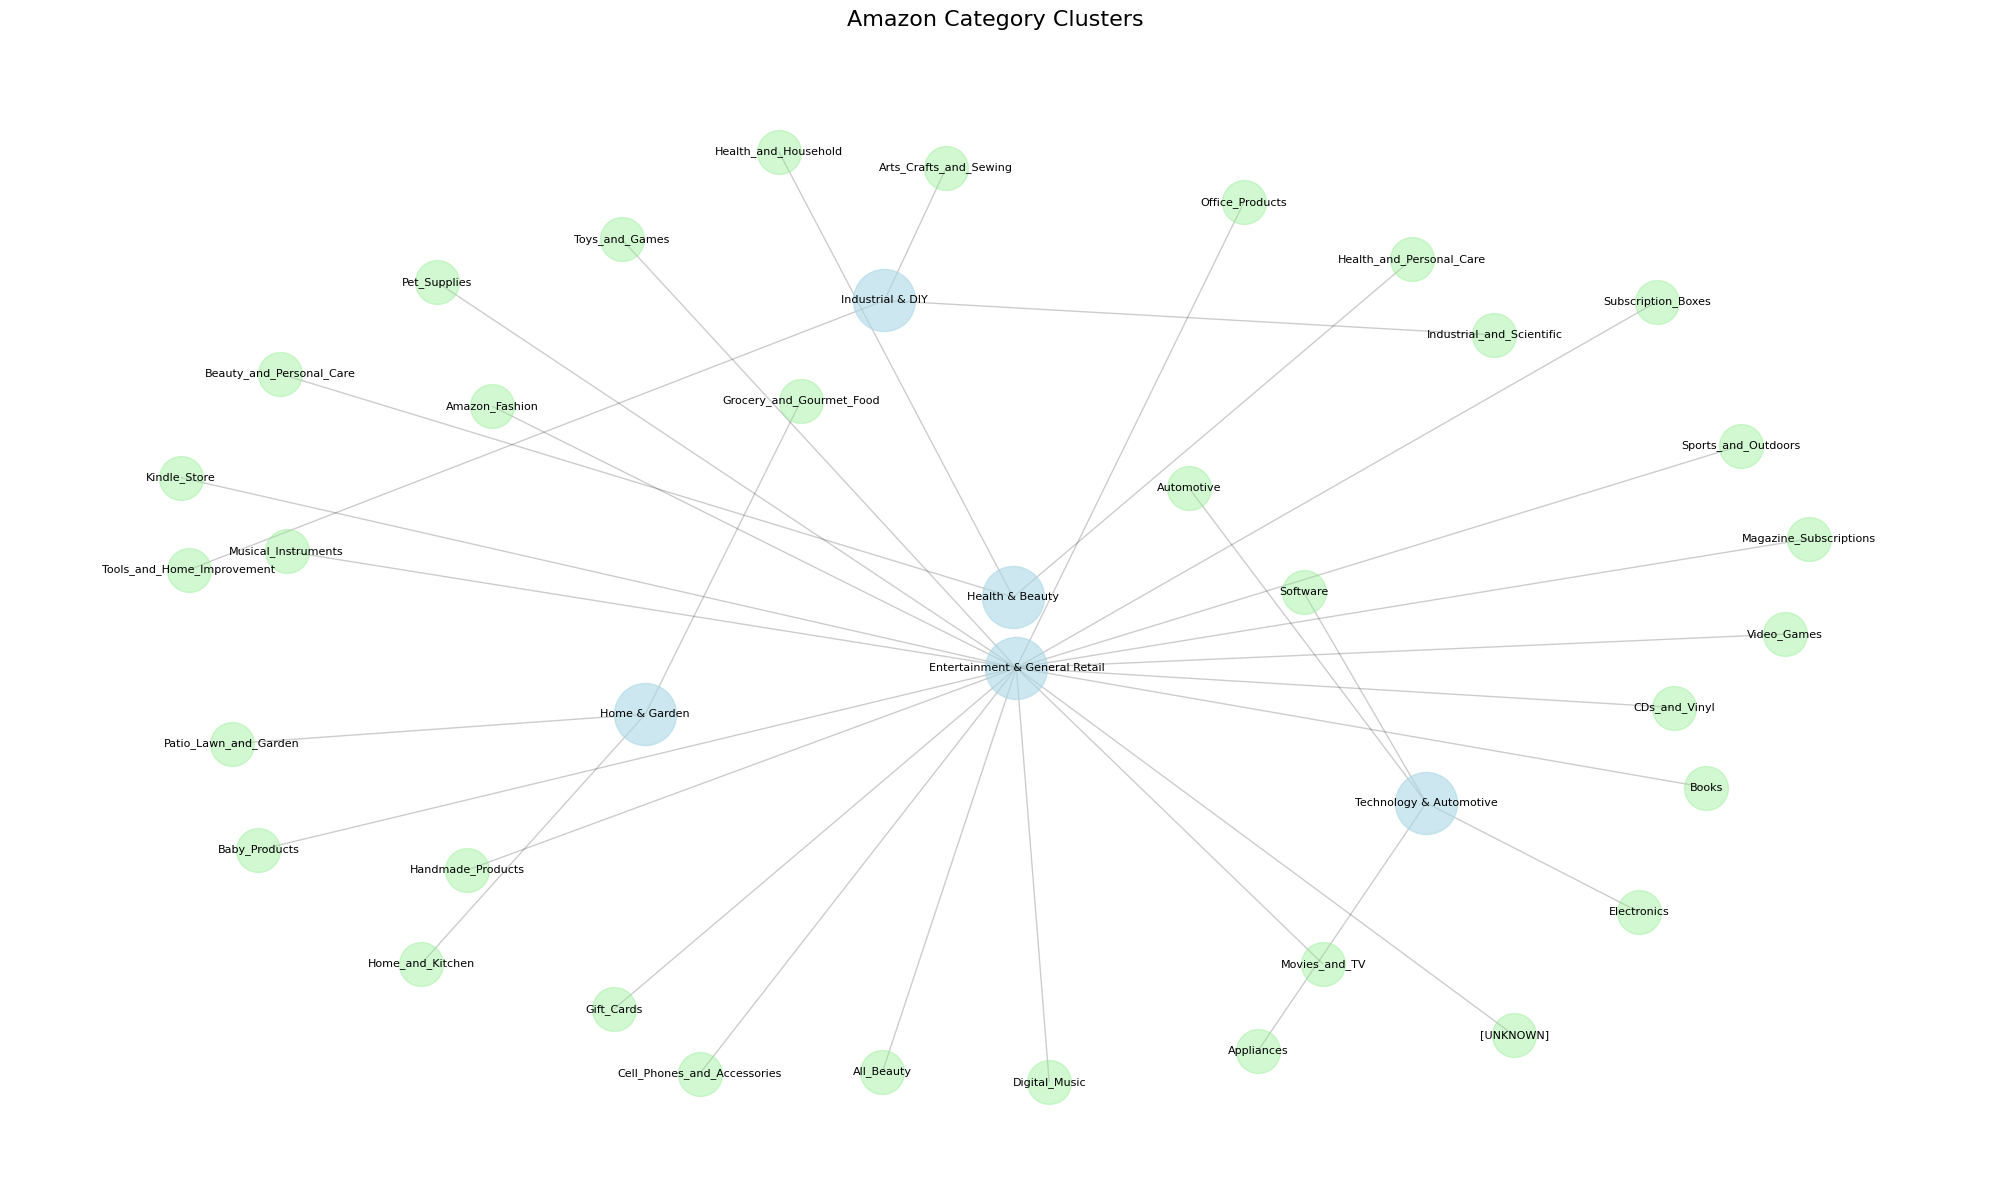

In [33]:
# Define meta-category names
meta_category_names = {
    0: "Entertainment & General Retail",  # Diverse consumer goods & entertainment
    1: "Technology & Automotive",         # Tech and vehicle related
    2: "Industrial & DIY",               # Tools and crafts
    3: "Health & Beauty",                # Personal care and health
    4: "Home & Garden"                   # Home, garden, and food
}

# Create visualization code
import matplotlib.pyplot as plt
import networkx as nx

def plot_category_clusters():
    # Create a graph
    G = nx.Graph()

    # Add nodes for meta-categories and their subcategories
    for cluster_id, categories in cluster_contents.items():
        meta_name = meta_category_names[cluster_id]
        G.add_node(meta_name, node_type='meta', size=2000)

        for category in categories:
            G.add_node(category, node_type='sub', size=1000)
            G.add_edge(meta_name, category)

    # Set up the plot
    plt.figure(figsize=(20, 12))
    pos = nx.spring_layout(G, k=1, iterations=50)

    # Draw meta-category nodes
    meta_nodes = [node for node, attr in G.nodes(data=True) if attr.get('node_type') == 'meta']
    nx.draw_networkx_nodes(G, pos, nodelist=meta_nodes, node_color='lightblue',
                          node_size=2000, alpha=0.6)

    # Draw subcategory nodes
    sub_nodes = [node for node, attr in G.nodes(data=True) if attr.get('node_type') == 'sub']
    nx.draw_networkx_nodes(G, pos, nodelist=sub_nodes, node_color='lightgreen',
                          node_size=1000, alpha=0.4)

    # Draw edges
    nx.draw_networkx_edges(G, pos, alpha=0.2)

    # Add labels
    nx.draw_networkx_labels(G, pos, font_size=8)

    plt.title("Amazon Category Clusters", fontsize=16, pad=20)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Create a sunburst chart
def plot_sunburst():
    import plotly.express as px

    # Prepare data for sunburst
    data = []
    for cluster_id, categories in cluster_contents.items():
        meta_name = meta_category_names[cluster_id]
        for category in categories:
            data.append({
                'Meta-Category': meta_name,
                'Category': category,
                'Value': 1
            })

    df_sunburst = pd.DataFrame(data)
    fig = px.sunburst(df_sunburst,
                      path=['Meta-Category', 'Category'],
                      values='Value',
                      title='Amazon Category Hierarchy')
    fig.show()

# Get cluster contents
cluster_contents = {}
for cluster in range(5):
    mask = cluster_labels == cluster
    cluster_contents[cluster] = [unique_categories[i] for i in np.where(mask)[0]]

# Create visualizations
plot_category_clusters()
plot_sunburst()

Cluster Metrics:
                    Meta-Category  Size  Avg Probability  Min Probability                                                                                                                                                                                                                                                                                                                            Categories
0  Entertainment & General Retail    20         0.999368         0.987350  Movies_and_TV, All_Beauty, Baby_Products, Video_Games, Kindle_Store, [UNKNOWN], Toys_and_Games, Books, Cell_Phones_and_Accessories, Pet_Supplies, Musical_Instruments, Amazon_Fashion, Office_Products, CDs_and_Vinyl, Sports_and_Outdoors, Digital_Music, Handmade_Products, Gift_Cards, Subscription_Boxes, Magazine_Subscriptions
1         Technology & Automotive     4         1.000000         1.000000                                                                                                              

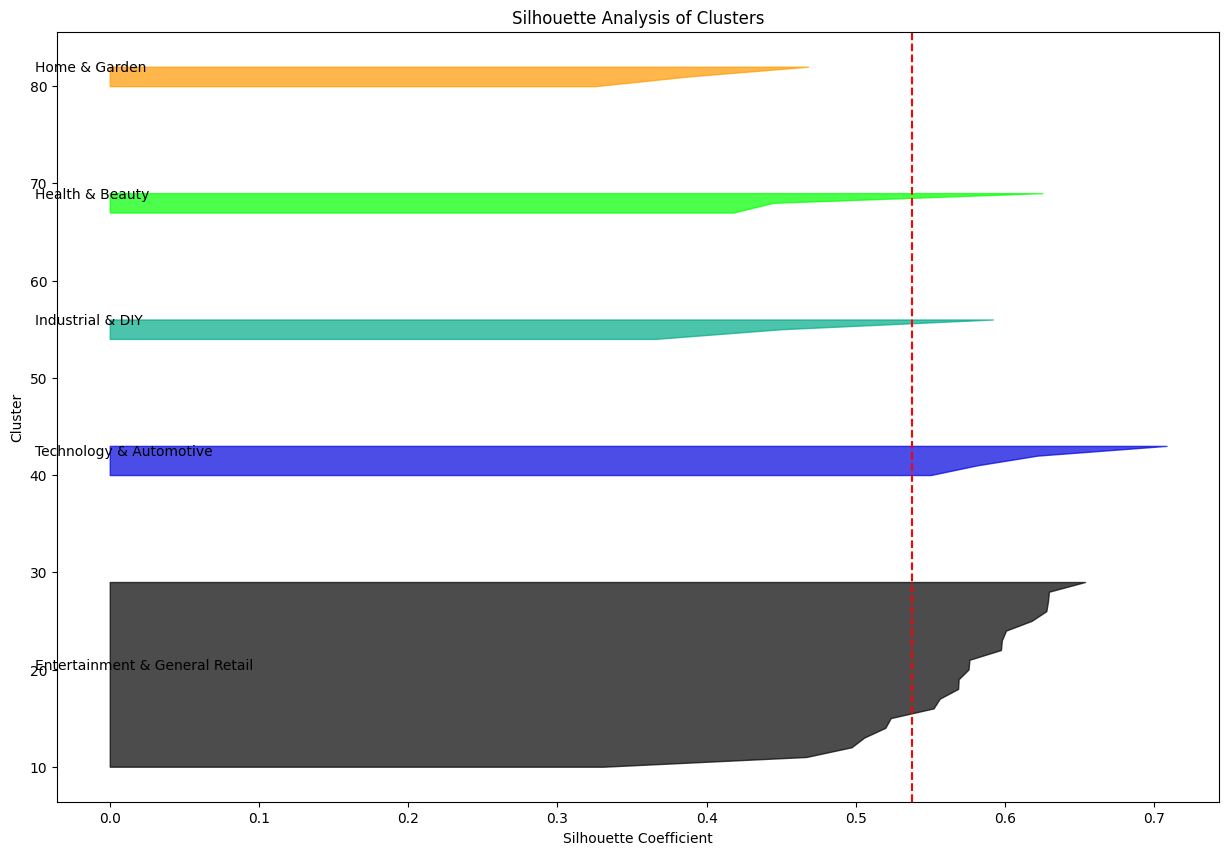

<ipython-input-34-9c30162480c5>:95: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.



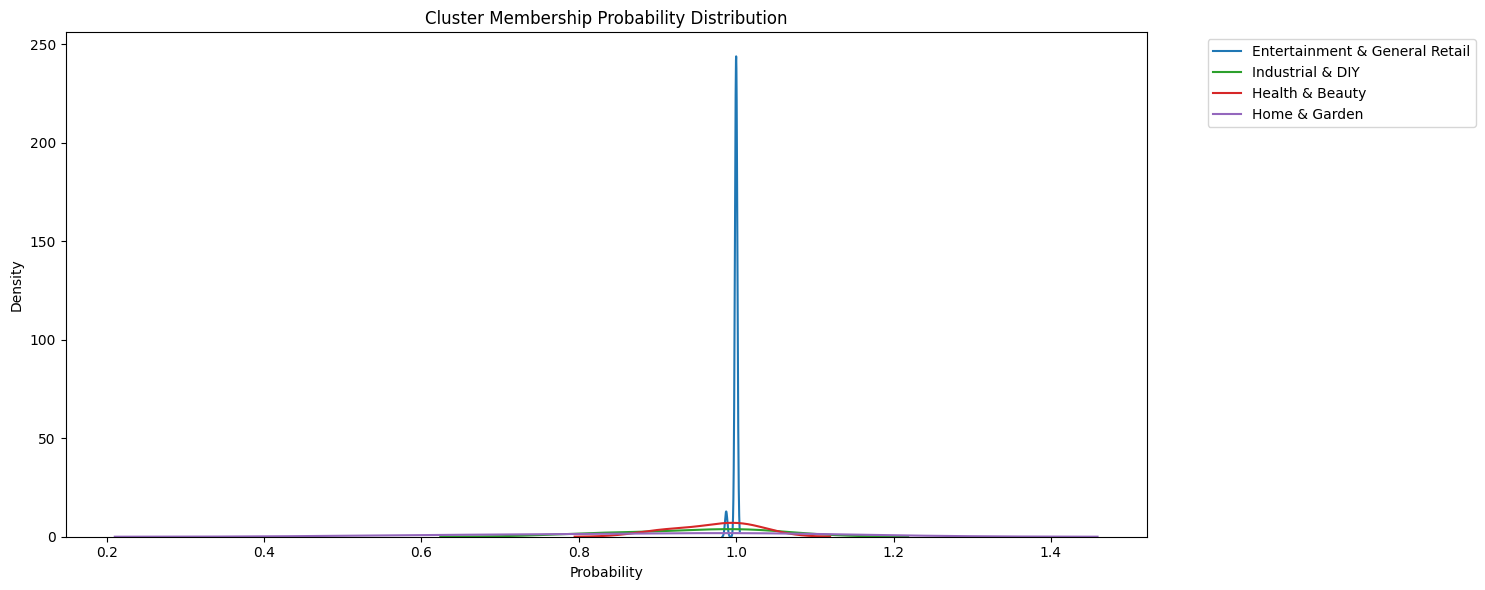

<ipython-input-34-9c30162480c5>:112: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

<ipython-input-34-9c30162480c5>:117: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



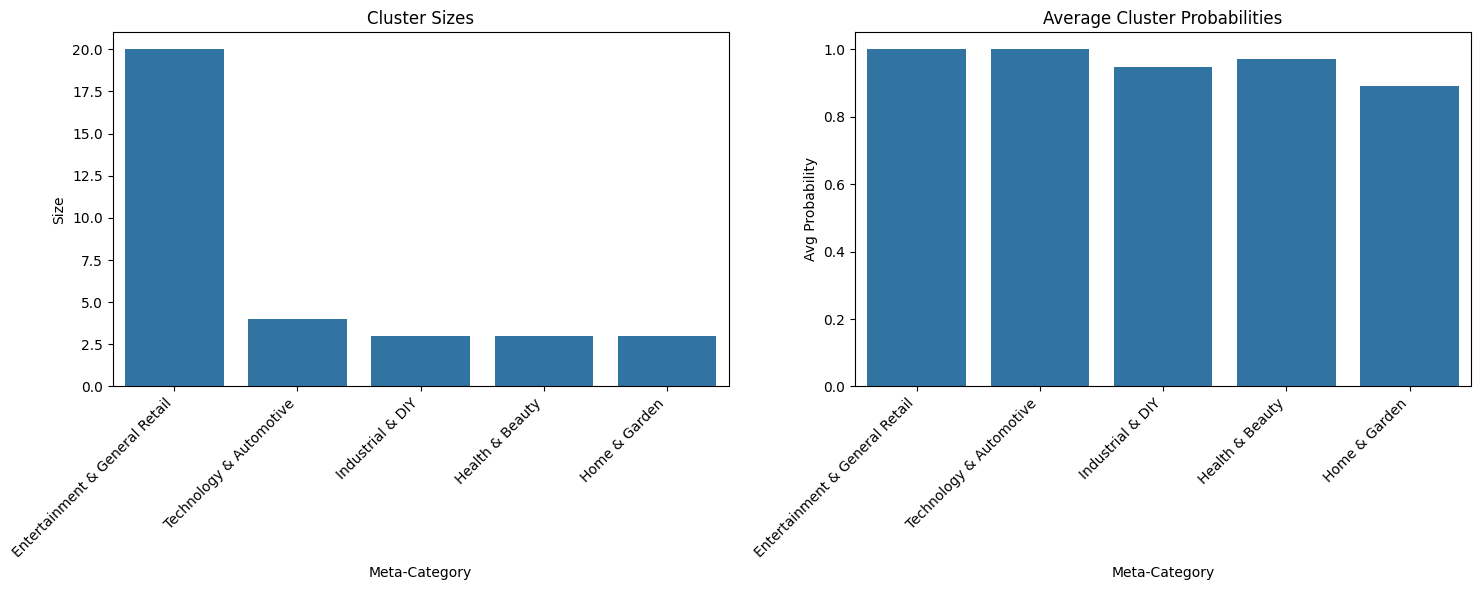

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import silhouette_samples

# Define meta-category names
meta_category_names = {
    0: "Entertainment & General Retail",
    1: "Technology & Automotive",
    2: "Industrial & DIY",
    3: "Health & Beauty",
    4: "Home & Garden"
}

# 1. Cluster Metrics Analysis
def analyze_cluster_metrics():
    metrics_df = pd.DataFrame()

    for cluster_id in range(5):
        mask = cluster_labels == cluster_id
        cluster_probs = clusterer.probabilities_[mask]
        cluster_categories = [unique_categories[i] for i in np.where(mask)[0]]

        metrics = {
            'Meta-Category': meta_category_names[cluster_id],
            'Size': len(cluster_categories),
            'Avg Probability': np.mean(cluster_probs),
            'Min Probability': np.min(cluster_probs),
            'Categories': ', '.join(cluster_categories)
        }
        metrics_df = pd.concat([metrics_df, pd.DataFrame([metrics])], ignore_index=True)

    return metrics_df

# 2. Treemap Visualization
def plot_treemap():
    data = []
    for cluster_id, categories in cluster_contents.items():
        meta_name = meta_category_names[cluster_id]
        for category in categories:
            mask = cluster_labels == cluster_id
            prob = clusterer.probabilities_[mask][list(cluster_contents[cluster_id]).index(category)]
            data.append({
                'Meta-Category': meta_name,
                'Category': category,
                'Probability': prob
            })

    df_treemap = pd.DataFrame(data)
    fig = px.treemap(df_treemap,
                     path=['Meta-Category', 'Category'],
                     values='Probability',
                     color='Probability',
                     title='Category Hierarchy with Membership Probabilities',
                     color_continuous_scale='RdYlBu')
    fig.show()

# 3. Silhouette Analysis Visualization
def plot_silhouette():
    silhouette_vals = silhouette_samples(umap_embeddings, cluster_labels)

    plt.figure(figsize=(15, 10))
    y_lower = 10

    for cluster_id in range(5):
        cluster_silhouette_vals = silhouette_vals[cluster_labels == cluster_id]
        cluster_silhouette_vals.sort()

        size_cluster = cluster_silhouette_vals.shape[0]
        y_upper = y_lower + size_cluster

        color = plt.cm.nipy_spectral(float(cluster_id) / 5)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                         0, cluster_silhouette_vals,
                         facecolor=color, edgecolor=color, alpha=0.7)

        plt.text(-0.05, y_lower + 0.5 * size_cluster, meta_category_names[cluster_id])
        y_lower = y_upper + 10

    plt.title("Silhouette Analysis of Clusters")
    plt.xlabel("Silhouette Coefficient")
    plt.ylabel("Cluster")
    plt.axvline(x=np.mean(silhouette_vals), color="red", linestyle="--")
    plt.show()

# 4. Probability Distribution
def plot_probability_distribution():
    plt.figure(figsize=(15, 6))

    for cluster_id in range(5):
        mask = cluster_labels == cluster_id
        cluster_probs = clusterer.probabilities_[mask]

        sns.kdeplot(data=cluster_probs, label=meta_category_names[cluster_id])

    plt.title("Cluster Membership Probability Distribution")
    plt.xlabel("Probability")
    plt.ylabel("Density")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# 5. Cluster Size and Average Probability Comparison
def plot_cluster_comparison():
    metrics = analyze_cluster_metrics()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Size comparison
    sns.barplot(data=metrics, x='Meta-Category', y='Size', ax=ax1)
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
    ax1.set_title('Cluster Sizes')

    # Probability comparison
    sns.barplot(data=metrics, x='Meta-Category', y='Avg Probability', ax=ax2)
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
    ax2.set_title('Average Cluster Probabilities')

    plt.tight_layout()
    plt.show()

# Run all visualizations and analysis
print("Cluster Metrics:")
print(analyze_cluster_metrics().to_string())
print("\nGenerating visualizations...")

plot_treemap()
plot_silhouette()
plot_probability_distribution()
plot_cluster_comparison()